# Gradient to Autoencoder

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [21]:
print(torch.cuda.get_device_name(0)) 
print(torch.cuda.is_available())
print(torch.version.cuda)
print(torch.__version__)
print(torch.cuda.current_device())
print(torch.cuda.device_count())

GPU_NUM = 1 # 원하는 GPU 번호 입력

device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device) # change allocation of current GPU

print ('Current cuda device ', torch.cuda.current_device()) # check

Quadro RTX 8000
True
11.1
1.8.0
0
3
Current cuda device  1


In [24]:
# Make dataloader

from torch.utils.data import TensorDataset

grad_list_znorm_stacked_regout = np.load(join(main_path,'result','latent_210', 'main_result/AE', 'grad_list_znorm_stacked_regout.npy'))


x_data = torch.tensor(grad_list_znorm_stacked_regout) # FC_list_vec_threshed FC_list_vec_removed FC_list_vec FC_list_vec_removed_choice
y_data = torch.tensor(y_scaled) # y_scaled y_choice_scaled
    
nsbj = len(x_data)

# list_idx = np.random.permutation(np.arange(nsbj))
itrain_idx = list_idx[:int(nsbj*0.6)]         # 100 subjects for training
itest_idx = list_idx[int(nsbj*0.6):int(nsbj*0.8)]       # 10  subjects for validation
otest_idx = list_idx[int(nsbj*0.8):]          # left subjects for test

grad_list_znorm_stacked_regout_lemon = np.load(join(main_path,'result','latent_210', 'validation', 'grad_list_znorm_stacked_regout.npy'))
lemon_data = torch.tensor(grad_list_znorm_stacked_regout_lemon)
                                               
x_train = x_data[itrain_idx]
x_valid = x_data[itest_idx]
x_test = x_data[otest_idx]
x_lemon = lemon_data

y_train = y_data[itrain_idx]
y_valid = y_data[itest_idx]
y_test = y_data[otest_idx]
y_lemon = torch.tensor(np.zeros(len(lemon_data)))

train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
test_ds = TensorDataset(x_test, y_test)
lemon_ds = TensorDataset(x_lemon, y_lemon)

from torch.utils.data import DataLoader
# from torch_geometric.data import DataLoader

bs_train = 10
bs_valid = 10
bs_test = 10
bs_lemon = 10

train_loader = DataLoader(train_ds, batch_size=bs_train, shuffle=False)
valid_loader = DataLoader(valid_ds, batch_size=bs_valid, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=bs_test, shuffle=False)
lemon_loader = DataLoader(lemon_ds, batch_size=bs_lemon, shuffle=False)

print(f'train : {len(itrain_idx)}, valid : {len(itest_idx)}, test : {len(otest_idx)}, lemon : {len(lemon_data)}')

train : 254, valid : 85, test : 85, lemon : 212


In [122]:
# Model construct

import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
    
    
fea_orig = 630 
fea1 = 420 
fea2 = 210 
fea3 = 120
    
    
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.dropout = nn.Dropout(p=0.3)
        self.encoder1 = nn.Sequential(
            nn.Linear(fea_orig, fea1),
            nn.Tanh())
#             nn.Dropout(p = 0.3))
        self.encoder2 = nn.Sequential(
            nn.Linear(fea1, fea2),
            nn.Tanh())
#             nn.Dropout(p = 0.4))
#         self.encoder3 = nn.Sequential(
#             nn.Linear(fea2, fea3),
#             nn.Tanh())

#         self.decoder3 = nn.Sequential(
#             nn.Linear(fea3, fea2),
#             nn.Tanh())
# # #             nn.Dropout(p = 0.2))
        self.decoder2 = nn.Sequential(
            nn.Linear(fea2, fea1),
            nn.Tanh())
#             nn.Dropout(p = 0.3))
        self.decoder1 = nn.Sequential(
            nn.Linear(fea1, fea_orig))
#             nn.Tanh())

    def forward(self, x):
        x = self.dropout(x)
        e1 = self.encoder1(x)
        latent = self.encoder2(e1)
#         latent = self.encoder3(e2)

#         d3 = self.decoder3(latent)
        d2 = self.decoder2(latent)
        x = self.decoder1(d2)
        
        return x, latent

class AutoEncoder_en(nn.Module):
    def __init__(self):
        super(AutoEncoder_en, self).__init__()
        self.dropout = nn.Dropout(p=0.3)
        self.encoder1 = nn.Sequential(
            nn.Linear(fea_orig, fea1),
            nn.Tanh())
#             nn.Dropout(p = 0.3))
        self.encoder2 = nn.Sequential(
            nn.Linear(fea1, fea2),
            nn.Tanh())

    def forward(self, x):
        x = self.dropout(x)
        e1 = self.encoder1(x)
        latent = self.encoder2(e1)
        
        return latent

# Train validate test process

In [124]:
def fit(model, dataloader, validloader, layer, loss_show = True):
    model.train()
    running_loss = 0.0
    running_KLD_loss = 0.0
    
    y_list = []
    y_hat_list = []
    x_list = []
    x_hat_list = []
    recon_loss_list = []
    reg_loss_list = []
    vae_loss_list = []
    
    total_predict = []
    total_y_pred = []
    cla_loss_list = []
    latent_train_list = []
    
    alpha = 1
    for i, data in enumerate(dataloader):
        x = data[0]
        x = x.to(device)
        x = x.view(x.size(0), -1)

        optimizer.zero_grad()
        

#         y = data[1]
#         y = y.to(device)
#         y = y.view(y.size(0), -1)
#             print('y',y)
        if layer == 'AE':
            x_hat, latent_train = model(x.float())
            recon_loss = criterion(x.float(), x_hat.float())
#             sparsity = sparse_loss(RHO, x.float())
            loss = recon_loss #+ sparsity * 0.1  # + criterion(output_e1.float(), output_d1.float()) + criterion(output_e2.float(), output_d2.float()) + criterion_reg(y.float(), y_hat.float())
    #             print(f'loss : {loss}')
#             print(f'recon_loss : {recon_loss}, sparsity : {sparsity}')

            x_list.append(x)
            x_hat_list.append(x_hat)
            recon_loss_list.append(recon_loss.item())
            latent_train_list.append(latent_train)
    #         del y

             
        del x
        torch.cuda.empty_cache()
        
        running_loss += loss.item()
        loss.backward(retain_graph = True)
        optimizer.step()
#         lr_decay.step()

#         print('output',output[:,:3])
#         print('data',data[:,:3])

    train_loss = running_loss/len(dataloader.dataset)
    if loss_show:
        print(f"Train Loss: {train_loss:.4f}")        
    
    val_loss, x_list_valid, x_hat_list_valid, recon_loss_list_valid, latent_valid_list = validate(model, validloader, layer)
    if loss_show:
        print(f"Val Loss: {val_loss:.4f}")
    
    return train_loss, val_loss, x_list, x_hat_list, x_list_valid, x_hat_list_valid, recon_loss_list, recon_loss_list_valid, latent_train_list, latent_valid_list


In [125]:
def validate(model, dataloader, layer):
    model.eval()
    running_loss = 0.0
    y_list = []
    y_hat_list = []
    x_hat_list = []
    x_list = []
    x_hat_list = []
    recon_loss_list = []
    reg_loss_list = []
    cla_loss_list = []
    vae_loss_list = []
    
    total_predict = []
    total_y_pred = []
    latent_valid_list = []
    
    alpha = 1
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            x = data[0]
            x = x.to(device)
            x = x.view(x.size(0), -1)
            
            
#             y = data[1]
#             y = y.to(device)
#             y = y.view(y.size(0), -1)
            if layer == 'AE':
                x_hat, latent_valid = model(x.float())
                recon_loss = criterion(x.float(), x_hat.float())
#                 sparsity = sparse_loss(RHO, x.float())
    #                 reg_loss = criterion_reg(y.float(), y_hat.float())
                loss = recon_loss #+ sparsity*0.1 # + criterion(output_e1.float(), output_d1.float()) + criterion(output_e2.float(), output_d2.float()) + criterion_reg(y.float(), y_hat.float())
    #                 print('recon_loss valid ', recon_loss)

                x_list.append(x)
                x_hat_list.append(x_hat)
                recon_loss_list.append(recon_loss.item())
                latent_valid_list.append(latent_valid)
    #                 reg_loss_list.append(reg_loss.item())
    #             del y
            
            del x
            running_loss += loss.item()
            
    val_loss = running_loss/len(dataloader.dataset)
    
    
    return val_loss, x_list, x_hat_list, recon_loss_list, latent_valid_list


# Model train

In [263]:
from copy import deepcopy
from torch.optim import Adam, lr_scheduler

layer = 'AE'

if layer == 'AE':
    model = AutoEncoder().to(device) # AutoEncoder 

model_children = list(model.children())

epochs = 500
lr = 0.0001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.1)
lr_decay = lr_scheduler.StepLR(optimizer, step_size = 10 ,gamma=0.95)
criterion = nn.MSELoss(reduction = 'sum')
criterion_reg = nn.MSELoss(reduction = 'sum') # nn.CrossEntropyLoss() nn.MSELoss()

save_path = join(main_path,'log')

best_model = deepcopy(model)
best_val_loss = np.inf



train_loss_total = []
val_loss_total = []
recon_loss_total_train = []
reg_loss_total_train = []
recon_loss_total_valid = []
reg_loss_total_valid = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, val_epoch_loss, x_train, x_hat_train, x_valid, x_hat_valid, recon_loss_list_train, recon_loss_list_valid, latent_train, latent_valid= fit(model, train_loader, valid_loader, layer, loss_show=True)
        

    train_loss_total.append(train_epoch_loss)
    val_loss_total.append(val_epoch_loss)
    recon_loss_total_train.append(recon_loss_list_train)
#     reg_loss_total_train.append(reg_loss_list_train)
    recon_loss_total_valid.append(recon_loss_list_valid)
#     reg_loss_total_valid.append(reg_loss_list_valid)
        
    if val_epoch_loss < best_val_loss:
        print('[Updated New Record!]')
        best_val_loss = val_epoch_loss
        best_model = deepcopy(model)
        best_epoch = epoch
#         best_y_train = y_train
#         best_y_hat_train = y_hat_train
#         best_y_valid = y_valid
#         best_y_hat_valid = y_hat_valid
        best_x_train = x_train
        best_x_hat_train = x_hat_train
        best_x_valid = x_valid
        best_x_hat_valid = x_hat_valid
    print('')
    
    if epoch > best_epoch +50:
        print('Stop!')
        break

    lr_decay.step()
    
# torch.save(best_model.state_dict(), save_path + '/' + trial + '_best_AE_epoch%d.pkl' % best_epoch)
print("best AE epoch to %d" % (best_epoch + 1))
print("best AE val_loss to %.4f" % best_val_loss)

Epoch 1 of 500
Train Loss: 208.4017
Val Loss: 202.9965
[Updated New Record!]

Epoch 2 of 500
Train Loss: 201.4646
Val Loss: 197.5848
[Updated New Record!]

Epoch 3 of 500
Train Loss: 193.0498
Val Loss: 190.1286
[Updated New Record!]

Epoch 4 of 500
Train Loss: 183.8802
Val Loss: 183.9998
[Updated New Record!]

Epoch 5 of 500
Train Loss: 176.4011
Val Loss: 179.3119
[Updated New Record!]

Epoch 6 of 500
Train Loss: 169.7794
Val Loss: 175.1883
[Updated New Record!]

Epoch 7 of 500
Train Loss: 163.6321
Val Loss: 171.4347
[Updated New Record!]

Epoch 8 of 500
Train Loss: 157.5966
Val Loss: 167.9910
[Updated New Record!]

Epoch 9 of 500
Train Loss: 152.2361
Val Loss: 164.9335
[Updated New Record!]

Epoch 10 of 500
Train Loss: 147.2117
Val Loss: 162.1306
[Updated New Record!]

Epoch 11 of 500
Train Loss: 143.0249
Val Loss: 159.6927
[Updated New Record!]

Epoch 12 of 500
Train Loss: 139.0256
Val Loss: 157.4752
[Updated New Record!]

Epoch 13 of 500
Train Loss: 135.5352
Val Loss: 155.3555
[Upda

In [3830]:
save_path = join(main_path,'log/grad.compare')
trial = '01'

torch.save(best_model.state_dict(), save_path + '/' + trial + '_best_AE_epoch%d.pkl' % best_epoch)

# Train set latent feature

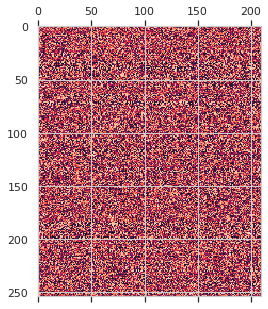

In [3707]:
plt.matshow(torch.cat(latent_train).detach().cpu().numpy())

# Reconstruction evaluate

In [3708]:
x = torch.cat(x_train).detach().cpu().numpy()
y = torch.cat(best_x_hat_train).detach().cpu().numpy()

corr_train = np.array([sc.stats.pearsonr(x[i],y[i])[0] for i in range(len(x))])
p_train = np.array([sc.stats.pearsonr(x[i],y[i])[1] for i in range(len(x))])

corr_train.mean()

0.8905542072220693

In [3709]:
x = torch.cat(x_valid).detach().cpu().numpy()
y = torch.cat(best_x_hat_valid).detach().cpu().numpy()

corr_valid = np.array([sc.stats.pearsonr(x[i],y[i])[0] for i in range(len(x))])
p_valid = np.array([sc.stats.pearsonr(x[i],y[i])[1] for i in range(len(x))])

corr_valid.mean()

0.7097592131028487

<Figure size 432x288 with 0 Axes>

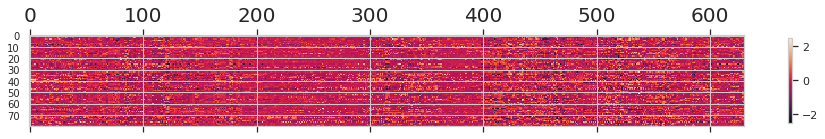

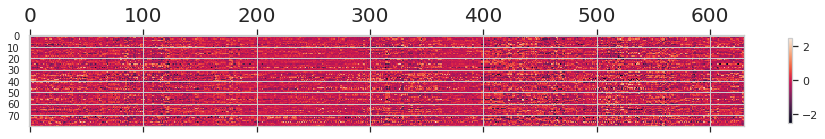

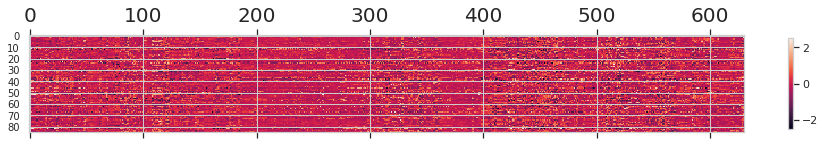

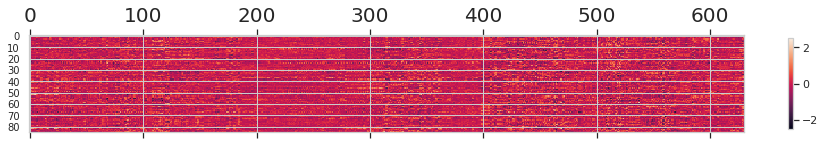

In [3710]:
plt.figure(1)
plt.matshow(torch.cat(x_train).detach().cpu().numpy()[:80])
plt.xticks(fontsize=20)
plt.yticks(fontsize=10)
plt.clim(-2.5,2.5)
plt.colorbar(shrink=0.75)


plt.figure(2)
plt.matshow(torch.cat(best_x_hat_train).detach().cpu().numpy()[:80])
plt.xticks(fontsize=20)
plt.yticks(fontsize=10)
plt.clim(-2.5,2.5)
plt.colorbar(shrink=0.75)

plt.figure(3)
plt.matshow(torch.cat(x_valid).detach().cpu().numpy())
plt.xticks(fontsize=20)
plt.yticks(fontsize=10)
plt.clim(-2.5,2.5)
plt.colorbar(shrink=0.75)

plt.figure(4)
plt.matshow(torch.cat(best_x_hat_valid).detach().cpu().numpy())
plt.xticks(fontsize=20)
plt.yticks(fontsize=10)
plt.clim(-2.5,2.5)
plt.colorbar(shrink=0.75)

# Loss 

In [45]:
def loss_plot(x, y, label_x, label_y):
    plt.figure(1, (7,5))
    plt.plot(x, label = label_x, color= 'k', linewidth=5)
    plt.plot(y, label = label_y, color = 'gray', linewidth=5)
#     plt.xlabel('Epochs')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend(fontsize = 15)

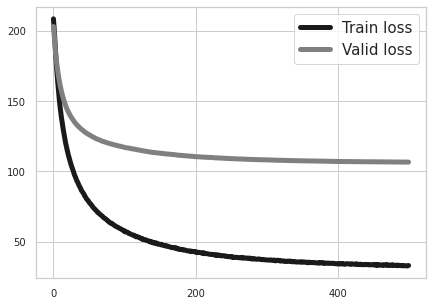

In [281]:
x = train_loss_total
y = val_loss_total

label_x = 'Train loss'
label_y = 'Valid loss'

loss_plot(x, y, label_x, label_y)